In [1]:
import copy
import datetime as dt
import importlib # needed so that we can reload packages
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import pandas as pd
import pathlib
import sys
import time
from typing import Union
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")

##  IMPORT SISEPUEDE EXAMPLES AND TRANSFORMERS

from sisepuede.manager.sisepuede_examples import SISEPUEDEExamples
from sisepuede.manager.sisepuede_file_structure import SISEPUEDEFileStructure
import sisepuede.core.support_classes as sc
import sisepuede.transformers as trf
import sisepuede.utilities._plotting as spu
import sisepuede.utilities._toolbox as sf

In [2]:
%load_ext autoreload
%autoreload 2

### Initial Set up

Make sure to edit the config yaml under croatia/config_files/croatia_config.yaml

You can also create a new config yaml



In [3]:
# Set up dir paths

dir_cur = pathlib.Path(os.getcwd())
dir_ssp_modeling = dir_cur.parent
dir_project = dir_ssp_modeling.parent
dir_data = dir_ssp_modeling.joinpath("input_data")
dir_scenario_mapping = dir_ssp_modeling.joinpath("scenario_mapping")
dir_config = dir_ssp_modeling.joinpath("config_files")
dir_transformations = dir_ssp_modeling.joinpath("transformations")
dir_misc = dir_ssp_modeling.joinpath("misc")
strategies_definitions_file_path = dir_transformations.joinpath("strategy_definitions.csv")
strategy_mapping_file_path = dir_misc.joinpath("strategy_mapping.yaml")

In [4]:
from ssp_transformations_handler.GeneralUtils import GeneralUtils
from ssp_transformations_handler.TransformationUtils import TransformationYamlProcessor, StrategyCSVHandler

# Initialize general utilities
g_utils = GeneralUtils()

In [5]:
# Load config file, double check your parameters are correct

yaml_file_path = os.path.join(dir_config, "config.yaml")
config_params = g_utils.get_yaml_values(yaml_file_path)

country_name = config_params['country_name']
ssp_input_file_name = config_params['ssp_input_file_name']
ssp_transformation_cw = config_params['ssp_transformation_cw']
energy_model_flag = config_params['energy_model_flag']


Country Name: peru
SSP Input File Name: inputs_lka_per_tza_built_20250225.csv
SSP Transformation CW: ssp_peru_transformation_2025_03_07.xlsx
Energy Model Flag: True


In [6]:
# Set up SSP objects

fp_data_base = dir_data.joinpath(ssp_input_file_name)

file_struct = SISEPUEDEFileStructure()

matt = file_struct.model_attributes
regions = sc.Regions(matt)
time_periods = sc.TimePeriods(matt)

### Making sure our input file has the correct format and correct columns
We use an example df with the complete fields and correct format to make sure our file is in the right shape

In [7]:
##  BUILD BASE INPUTS
df_inputs_raw = pd.read_csv(fp_data_base)

# pull example data to fill in gaps
examples = SISEPUEDEExamples()
df_inputs_example = examples.input_data_frame

In [8]:
?g_utils.check_frac_groups

Signature: g_utils.check_frac_groups(ssp_input_df, frac_vars_mapping_file_path)
Docstring:
Checks if the sum of fractional groups in the input DataFrame is within the range [0, 1].
This function reads a mapping file to identify subgroups of columns in the input DataFrame.
For each subgroup, it calculates the row-wise sum of the columns and checks if the sums are within the range [0, 1].
If any row sum is outside this range, a message is printed indicating the issue.
Args:
    ssp_input_df (pd.DataFrame): The input DataFrame containing the data to be checked.
    frac_vars_mapping_file_path (str): The file path to the Excel file containing the mapping of fractional variables.
Returns:
    None
File:      ~/anaconda3/envs/ssp_tanzania/lib/python3.11/site-packages/ssp_transformations_handler/GeneralUtils.py
Type:      function

In [9]:
# Checking regions in df_inputs_raw
df_inputs_raw['region'].unique()

array(['peru', 'sri_lanka', 'united_republic_of_tanzania'], dtype=object)

In [10]:
# Filter df_input_raw to peru
df_inputs_raw = df_inputs_raw[df_inputs_raw['region'] == 'peru']

# Reset index
df_inputs_raw.reset_index(drop=True, inplace=True)

In [11]:
# Checking regions in df_inputs_raw
df_inputs_raw['region'].unique()

array(['peru'], dtype=object)

In [12]:
# Check frac variables in df_inputs_raw
# g_utils.check_frac_groups(df_inputs_raw, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

In [13]:
# g_utils.check_individual_frac_vars(df_inputs_raw)

In [14]:
# Checks if there are any differences in columns between the example df and our df
g_utils.compare_dfs(df_inputs_example, df_inputs_raw)


Columns in df_example but not in df_input: {'strategy_id'}
Columns in df_input but not in df_example: {'demscalar_ippu_recycled_plastic', 'nemomod_entc_variable_cost_pp_wind_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_wind_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_solar_mm_usd_per_mwh', 'demscalar_ippu_recycled_glass', 'nemomod_entc_variable_cost_pp_gas_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_geothermal_mm_usd_per_gw', 'demscalar_ippu_recycled_textiles', 'nemomod_entc_variable_cost_pp_coal_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biomass_mm_usd_per_gw', 'demscalar_ippu_recycled_wood', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biomass_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_gw', 'nem

In [15]:
# Check for duplicated col names
duplicated_columns = df_inputs_raw.columns[df_inputs_raw.columns.duplicated()].tolist()
print(duplicated_columns)

[]


In [16]:
help(g_utils.remove_additional_cols)

Help on function remove_additional_cols in module ssp_transformations_handler.GeneralUtils:

remove_additional_cols(df_example, df_input)
    Remove columns from df_input that are not present in df_example.
    Parameters:
    df_example (pandas.DataFrame): The reference DataFrame containing the desired columns.
    df_input (pandas.DataFrame): The DataFrame from which additional columns will be removed.
    Returns:
    pandas.DataFrame: A DataFrame with only the columns present in df_example.



In [17]:
# Fixes differences and makes sure that our df is in the correct format.
# Note: Edit this if you need more changes in your df

df_inputs_raw = df_inputs_raw.rename(columns={'period':'time_period'})
# df_inputs_raw_complete = g_utils.add_missing_cols(df_inputs_example, df_inputs_raw.copy())
# df_inputs_raw_complete = g_utils.remove_additional_cols(df_inputs_example, df_inputs_raw.copy())
df_inputs_raw_complete = df_inputs_raw.drop(columns='iso_code3', errors='ignore')
df_inputs_raw_complete.head()

,ef_lndu_conv_wetlands_to_wetlands_gg_co2_ha,frac_agrc_cereals_cl1_temperate,ef_lndu_conv_croplands_to_grasslands_gg_co2_ha,pij_lndu_settlements_to_croplands,pop_lvst_initial_horses,frac_lvst_mm_goats_anaerobic_lagoon,pij_lndu_forests_primary_to_settlements,frac_lvst_mm_chickens_daily_spread,frac_agrc_vegetables_and_vines_cl1_tropical,frac_lvst_mm_horses_dry_lot,...,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_electrolysis_water,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_electricity,energydensity_gravimetric_enfu_gj_per_tonne_fuel_ammonia,energydensity_gravimetric_enfu_gj_per_tonne_fuel_water,frac_trns_fuelmix_water_borne_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_ammonia_production_ammonia,nemomod_entc_output_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_hydrogen,nemomod_entc_frac_min_share_production_fp_hydrogen_reformation_ccs,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_natural_gas,nemomod_entc_input_activity_ratio_fuel_production_fp_hydrogen_reformation_ccs_oil
0,0.0,0.442621,0.0,0.0,743424.0,0.0,0.0,0.166667,0.557379,0.265,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
1,0.0,0.442621,0.0,0.0,743757.0,0.0,0.0,0.166667,0.557379,0.265,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
2,0.0,0.442621,0.0,0.0,748793.0,0.0,0.0,0.166667,0.557379,0.265,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
3,0.0,0.442621,0.0,0.0,749589.0,0.0,0.0,0.166667,0.557379,0.265,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0
4,0.0,0.442621,0.0,0.0,750910.0,0.0,0.0,0.166667,0.557379,0.265,...,0.000004,0,18.6,0.00005,0.0,1,1,0.0,1.315,0.0


In [18]:
# Double checking that our df is in the correct shape (Empty sets should be printed to make sure everything is Ok!)
g_utils.compare_dfs(df_inputs_example, df_inputs_raw_complete)

Columns in df_example but not in df_input: {'strategy_id'}
Columns in df_input but not in df_example: {'demscalar_ippu_recycled_plastic', 'nemomod_entc_variable_cost_pp_wind_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_wind_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_solar_mm_usd_per_mwh', 'demscalar_ippu_recycled_glass', 'nemomod_entc_variable_cost_pp_gas_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_geothermal_mm_usd_per_gw', 'demscalar_ippu_recycled_textiles', 'nemomod_entc_variable_cost_pp_coal_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biogas_mm_usd_per_gw', 'nemomod_entc_variable_cost_pp_ocean_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biomass_mm_usd_per_gw', 'demscalar_ippu_recycled_wood', 'nemomod_entc_variable_cost_pp_nuclear_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_biomass_mm_usd_per_mwh', 'nemomod_entc_variable_cost_pp_oil_mm_usd_per_gw', 'nem

In [19]:
# Checking region to avoid copy errors
df_inputs_raw_complete['region'].head()

0    peru
1    peru
2    peru
3    peru
4    peru
Name: region, dtype: object

In [20]:
# # Set region to country name
# df_inputs_raw_complete['region'] = country_name
# df_inputs_raw_complete['region'].head()

In [21]:
# g_utils.check_frac_groups(df_inputs_raw_complete, os.path.join(dir_misc, "energy_frac_vars.xlsx"))

In [22]:
# g_utils.check_individual_frac_vars(df_inputs_raw_complete)

#  Let's try building transformations using this


In [23]:
transformers = trf.transformers.Transformers(
    {},
    df_input = df_inputs_raw_complete,
)

##  Instantiate some transformations. Make sure to run this cell to create the transformations folder for the first time or if you wish to overwrite

In [24]:
# set an ouput path and instantiate
if not dir_transformations.exists():
    trf.instantiate_default_strategy_directory(
        transformers,
        dir_transformations,
    )
else:
    print(f"Directory {dir_transformations} already exists. Skipping instantiation.")


##  --HERE, CUSTOMIZE YOUR TRANSFORMATIONS AND STRATEGIES--

### Customizing transformations and strategies files using TransformationUtils.py classes

In [25]:
?TransformationYamlProcessor

Init signature:
TransformationYamlProcessor(
    scenario_mapping_excel_path,
    yaml_dir_path,
    sheet_name='yaml',
)
Docstring:     
TransformationYamlProcessor is a class designed to handle the processing of YAML files based on scenario mappings provided in an Excel file. It provides methods to load scenario mappings, retrieve strategy names, load YAML data, save modified YAML files, and process YAML files according to specified transformations.
Methods:
    __init__(self, scenario_mapping_excel_path, yaml_dir_path, sheet_name='yaml'):
        Initializes the TransformationYamlProcessor class with the given parameters.
    load_scenario_mapping_excel(self):
    load_yaml_data(self, yaml_file_path):
    get_strategy_names(self):
    save_yaml_file(self, yaml_content, yaml_name, column, transformation_code, subsector, transformation_name, scalar_val):
    get_transformations_per_strategy_dict(self):
    process_yaml_files(self):
Init docstring:
Initializes the TransformationUtils c

In [26]:
# Generate new transformation files based on the excel mapping file. 
# Make sure to have the most updated format for the excel file, check the one used in this notebook for reference.

cw_file_path = os.path.join(dir_scenario_mapping, ssp_transformation_cw)
print(cw_file_path)
excel_yaml_handler = TransformationYamlProcessor(scenario_mapping_excel_path=cw_file_path, yaml_dir_path=dir_transformations)

/home/tony-ubuntu/decision_sciences/ssp_peru/ssp_modeling/scenario_mapping/ssp_peru_transformation_2025_03_07.xlsx


In [27]:
# This creates transformation yaml files for each strategy in the excel file
excel_yaml_handler.process_yaml_files()

Created new YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NDC_uncon and set to default because its a special case
Created new YAML file transformation_agrc_inc_conservation_agriculture.yaml for strategy strategy_NDC_con and set to default because its a special case
Created new YAML file transformation_wali_inc_treatment_industrial.yaml for strategy strategy_NDC_uncon and set to default because its a special case
Created new YAML file transformation_wali_inc_treatment_industrial.yaml for strategy strategy_NDC_con and set to default because its a special case
Created new YAML file transformation_wali_inc_treatment_rural.yaml for strategy strategy_NDC_uncon and set to default because its a special case
Created new YAML file transformation_wali_inc_treatment_rural.yaml for strategy strategy_NDC_con and set to default because its a special case
Created new YAML file transformation_wali_inc_treatment_urban.yaml for strategy strategy_NDC_uncon and set t

In [28]:
# Load the transformations per strategy dictionary so we can pass it to the strategy handler
# You can also check here if the transformations in each strategy are correct
transformation_per_strategy_dict = excel_yaml_handler.get_transformations_per_strategy_dict()
transformation_per_strategy_dict

{'strategy_NDC_uncon': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC_UNCON',
  'TX:AGRC:DEC_EXPORTS_STRATEGY_NDC_UNCON',
  'TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_STRATEGY_NDC_UNCON',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC_UNCON',
  'TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC_UNCON',
  'TX:IPPU:DEC_CLINKER_STRATEGY_NDC_UNCON',
  'TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC_UNCON',
  'TX:LNDU:DEC_SOC_LOSS_PASTURES_STRATEGY_NDC_UNCON',
  'TX:LNDU:INC_REFORESTATION_STRATEGY_NDC_UNCON',
  'TX:LNDU:INC_SILVOPASTURE_STRATEGY_NDC_UNCON',
  'TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_STRATEGY_NDC_UNCON',
  'TX:TRNS:SHIFT_MODE_PASSENGER_STRATEGY_NDC_UNCON',
  'TX:WALI:INC_TREATMENT_INDUSTRIAL_STRATEGY_NDC_UNCON',
  'TX:WALI:INC_TREATMENT_RURAL_STRATEGY_NDC_UNCON',
  'TX:WALI:INC_TREATMENT_URBAN_STRATEGY_NDC_UNCON'],
 'strategy_NDC_con': ['TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC_CON',
  'TX:AGRC:DEC_EXPORTS_STRATEGY_NDC_CON',
  'TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_STRATEGY_NDC_CON',
  'TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY

### Creating new strategies
- You can create new strategies from scratch.
- You can also update existing ones.

In [29]:
?StrategyCSVHandler

Init signature:
StrategyCSVHandler(
    csv_file_path,
    yaml_dir_path,
    yaml_mapping_file,
    transformation_per_strategy_dict,
)
Docstring:     
A class to handle strategy CSV files and YAML mappings for transformations.
Methods:
    __init__(csv_file_path, yaml_dir_path, yaml_mapping_file, transformation_per_strategy_dict):
        Initializes the StrategyCSVHandler class with the given parameters.
    load_strategy_definitions_csv():
    load_yaml_mapping():
    get_strategy_id(strategy_group):
    get_strategy_code(strategy_group, strategy_name):
    get_transformation_specification(yaml_file_suffix):
    save_csv():
    add_strategy(strategy_group, description, yaml_file_suffix):
Init docstring:
Initializes the TransformationUtils class with the given parameters.

Args:
    csv_file_path (str): The file path to the CSV file containing strategy definitions.
    yaml_dir_path (str): The directory path where YAML files are located.
    yaml_mapping_file (str): The file name of

In [30]:
# Creating new strategies by updating the strategy_definitions file.
# You can edit this to add yours, as many as you want.
csv_handler = StrategyCSVHandler(strategies_definitions_file_path, dir_transformations, strategy_mapping_file_path, transformation_per_strategy_dict)

csv_handler.add_strategy(strategy_group='PFLO', description='NDC Unconditional', yaml_file_suffix='NDC_uncon')
csv_handler.add_strategy(strategy_group='PFLO', description='NDC Conditional', yaml_file_suffix='NDC_con')


Updated file with new row: {'strategy_id': 6003, 'strategy_code': 'PFLO:NDC_UNCON', 'strategy': 'NDC_uncon', 'description': 'NDC Unconditional', 'transformation_specification': 'TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_STRATEGY_NDC_UNCON|TX:WALI:INC_TREATMENT_RURAL_STRATEGY_NDC_UNCON|TX:AGRC:INC_PRODUCTIVITY_STRATEGY_NDC_UNCON|TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN_STRATEGY_NDC_UNCON|TX:LNDU:DEC_SOC_LOSS_PASTURES_STRATEGY_NDC_UNCON|TX:IPPU:DEC_CLINKER_STRATEGY_NDC_UNCON|TX:WALI:INC_TREATMENT_INDUSTRIAL_STRATEGY_NDC_UNCON|TX:AGRC:DEC_CH4_RICE_STRATEGY_NDC_UNCON|TX:TRNS:SHIFT_MODE_PASSENGER_STRATEGY_NDC_UNCON|TX:LNDU:INC_SILVOPASTURE_STRATEGY_NDC_UNCON|TX:LNDU:DEC_DEFORESTATION_STRATEGY_NDC_UNCON|TX:LNDU:INC_REFORESTATION_STRATEGY_NDC_UNCON|TX:WALI:INC_TREATMENT_URBAN_STRATEGY_NDC_UNCON|TX:AGRC:INC_CONSERVATION_AGRICULTURE_STRATEGY_NDC_UNCON|TX:AGRC:DEC_EXPORTS_STRATEGY_NDC_UNCON'}
Updated file with new row: {'strategy_id': 6004, 'strategy_code': 'PFLO:NDC_CON', 'strategy': 'NDC_con', 'description': 'NDC 

In [31]:
# Set up the strategy codes you wish to run in ssp
strategies_to_run = [0, 6003, 6004]

### We finished adding new transformation files and strategies so lets load them back

In [32]:
# then, you can load this back in after modifying (play around with it)
transformations = trf.Transformations(
    dir_transformations,
    transformers = transformers,
)
tab = transformations.attribute_transformation.table

In [33]:
#  build the strategies -- will export to path
t0 = time.time()
strategies = trf.Strategies(
    transformations,
    export_path = "transformations",
    prebuild = True,
)

t_elapse = sf.get_time_elapsed(t0)
print(f"Strategies defined at {strategies.transformations.dir_init} initialized in {t_elapse} seconds")

Strategies defined at /home/tony-ubuntu/decision_sciences/ssp_peru/ssp_modeling/transformations initialized in 2.95 seconds


In [34]:
strategies.attribute_table

,strategy_id,strategy_code,strategy,description,transformation_specification,baseline_strategy_id
0,0,BASE,Strategy TX:BASE,NaN,TX:BASE,1
1,1000,AGRC:DEC_CH4_RICE,Singleton - Default Value - AGRC: Improve rice...,NaN,TX:AGRC:DEC_CH4_RICE,0
2,1001,AGRC:DEC_EXPORTS,Singleton - Default Value - AGRC: Decrease Exp...,NaN,TX:AGRC:DEC_EXPORTS,0
3,1002,AGRC:DEC_LOSSES_SUPPLY_CHAIN,Singleton - Default Value - AGRC: Reduce suppl...,NaN,TX:AGRC:DEC_LOSSES_SUPPLY_CHAIN,0
4,1003,AGRC:INC_CONSERVATION_AGRICULTURE,Singleton - Default Value - AGRC: Expand conse...,NaN,TX:AGRC:INC_CONSERVATION_AGRICULTURE,0
...,...,...,...,...,...,...
66,6000,PFLO:INC_HEALTHIER_DIETS,Singleton - Default Value - PFLO: Change diets,NaN,TX:PFLO:INC_HEALTHIER_DIETS,0
67,6001,PFLO:INC_IND_CCS,Singleton - Default Value - PFLO: Industrial c...,NaN,TX:PFLO:INC_IND_CCS,0
68,6002,PFLO:ALL,All Actions,All actions (unique by transformer),TX:AGRC:DEC_CH4_RICE|TX:AGRC:DEC_EXPORTS|TX:AG...,0
69,6003,PFLO:NDC_UNCON,NDC_uncon,NDC Unconditional,TX:TRNS:SHIFT_FUEL_LIGHT_DUTY_STRATEGY_NDC_UNC...,0


##  Build our templates
- let's use the default variable groupings for LHS

In [35]:
# Building excel templates, make sure to include the strategies ids in the strategies attribute as well as the baseline (0)
df_vargroups = examples("variable_trajectory_group_specification")

strategies.build_strategies_to_templates(
    df_trajgroup = df_vargroups,
    include_simplex_group_as_trajgroup = True,
    strategies = strategies_to_run,
)

starting strat 6003 with input shape (36, 2260)
strat 6003 with output shape (36, 2260)
here = 6003
starting strat 6004 with input shape (36, 2260)
strat 6004 with output shape (36, 2260)
here = 6004


0

# Finally, load SISEPUEDE so that we can run it

In [36]:
country_name

'peru'

In [37]:
import sisepuede as si
# timestamp_str = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
ssp = si.SISEPUEDE(
    "calibrated",
    db_type = "csv",
    # id_str = f"sisepuede_run_2024-11-04T09:23:26.721580",
    initialize_as_dummy = not(energy_model_flag), # no connection to Julia is initialized if set to True
    regions = [country_name],
    strategies = strategies,
    try_exogenous_xl_types_in_variable_specification = True,
)

2025-03-07 18:46:21,746 - INFO - Successfully initialized SISEPUEDEFileStructure.
2025-03-07 18:46:21,748 - WARNING - Missing key dict_dimensional_keys: key time_series not found. Tables that rely on the time_series will not have index checking.
2025-03-07 18:46:21,749 - INFO - 	Setting export engine to 'csv'.
2025-03-07 18:46:21,750 - WARNING - No index fields defined. Index field values will not be checked when writing to tables.
2025-03-07 18:46:21,750 - INFO - Successfully instantiated table ANALYSIS_METADATA
2025-03-07 18:46:21,751 - WARNING - No index fields found in ATTRIBUTE_DESIGN. Initializing index fields.
2025-03-07 18:46:21,751 - INFO - Successfully instantiated table ATTRIBUTE_DESIGN
2025-03-07 18:46:21,752 - WARNING - No index fields found in ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES. Initializing index fields.
2025-03-07 18:46:21,752 - INFO - Successfully instantiated table ATTRIBUTE_LHC_SAMPLES_EXOGENOUS_UNCERTAINTIES
2025-03-07 18:46:21,753 - WARNING - No index fi

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


Precompiling NemoMod...
Info Given NemoMod was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
   2365.6 ms  ? NemoMod
[ Info: Precompiling NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72] 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing NemoMod [a3c327a0-d2f0-11e8-37fd-d12fd35c3c72].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
2025-03-07 18:47:24,615 - INFO - Successfully initialized JuMP optimizer from solver module HiGHS.
2025-03-07 18:47:24,649 - INFO - Successfully initialized SISEPUEDEModels.
2025-03-07 18:47:24,663 - INFO - Table ANALYSIS_METADATA successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_tanzania/lib/pytho

In [38]:
not(energy_model_flag)

False

In [39]:
# This runs the model, make sure you edit key_stretegy with the strategy ids you want to execute include baseline (0)
dict_scens = {
    ssp.key_design: [0],
    ssp.key_future: [0],
    ssp.key_strategy: strategies_to_run,
}

ssp.project_scenarios(
    dict_scens,
    save_inputs = True,
    include_electricity_in_energy = energy_model_flag
)

2025-03-07 18:47:24,980 - INFO - 
***	STARTING REGION peru	***



2025-03-07 18:47:29,214 - INFO - Trying run primary_id = 0 in region peru
2025-03-07 18:47:29,215 - INFO - Running AFOLU model
2025-03-07 18:47:29,454 - INFO - AFOLU model run successfully completed
2025-03-07 18:47:29,455 - INFO - Running CircularEconomy model
2025-03-07 18:47:29,528 - INFO - CircularEconomy model run successfully completed
2025-03-07 18:47:29,529 - INFO - Running IPPU model
2025-03-07 18:47:29,633 - INFO - IPPU model run successfully completed
2025-03-07 18:47:29,634 - INFO - Running Energy model (EnergyConsumption without Fugitive Emissions)
2025-03-07 18:47:29,662 - DEBUG - Missing elasticity information found in 'project_energy_consumption_by_fuel_from_effvars': using specified future demands.
2025-03-07 18:47:29,782 - INFO - EnergyConsumption without Fugitive Emissions model run successfully completed
2025-03-07 18:47:29,783 - INFO - Running Energy model (Electricity and Fuel Production: trying to call Julia)
2025-03-07 18:47:29,823 - INFO - 	Path to temporary Ne

2025-07-Mar 18:47:30.685 Opened SQLite database at /home/tony-ubuntu/anaconda3/envs/ssp_tanzania/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-07-Mar 18:47:31.080 Added NEMO structure to SQLite database at /home/tony-ubuntu/anaconda3/envs/ssp_tanzania/lib/python3.11/site-packages/sisepuede/tmp/nemomod_intermediate_database.sqlite.
2025-07-Mar 18:47:49.651 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-07-Mar 18:49:12.333 Finished modeling scenario.


2025-03-07 18:49:12,694 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-03-07 18:49:12,724 - INFO - EnergyProduction model run successfully completed
2025-03-07 18:49:12,726 - INFO - Running Energy (Fugitive Emissions)
2025-03-07 18:49:12,787 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-03-07 18:49:12,788 - INFO - Appending Socioeconomic outputs
2025-03-07 18:49:12,803 - INFO - Socioeconomic outputs successfully appended.
2025-03-07 18:49:12,818 - INFO - Model run for primary_id = 0 successfully completed in 103.6 seconds (n_tries = 1).
2025-03-07 18:49:12,848 - INFO - Trying run primary_id = 69069 in region peru
2025-03-07 18:49:12,849 - INFO - Running AFOLU model
2025-03-07 18:49:13,113 - INFO - AFOLU model run successfully completed
2025-03-07 18:49:13,114 - INFO - Running CircularEconomy model
2025-03-07 18:49:13,184 - INFO - CircularEconomy model run successfully completed
2025-03-07 18:49:13,186 - INFO - Running IPPU mode

2025-07-Mar 18:49:15.653 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-07-Mar 18:50:11.853 Finished modeling scenario.


2025-03-07 18:50:12,194 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-03-07 18:50:12,220 - INFO - EnergyProduction model run successfully completed
2025-03-07 18:50:12,221 - INFO - Running Energy (Fugitive Emissions)
2025-03-07 18:50:12,291 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-03-07 18:50:12,293 - INFO - Appending Socioeconomic outputs
2025-03-07 18:50:12,307 - INFO - Socioeconomic outputs successfully appended.
2025-03-07 18:50:12,317 - INFO - Model run for primary_id = 69069 successfully completed in 59.47 seconds (n_tries = 1).
2025-03-07 18:50:12,329 - INFO - Trying run primary_id = 70070 in region peru
2025-03-07 18:50:12,330 - INFO - Running AFOLU model
2025-03-07 18:50:12,669 - INFO - AFOLU model run successfully completed
2025-03-07 18:50:12,670 - INFO - Running CircularEconomy model
2025-03-07 18:50:12,743 - INFO - CircularEconomy model run successfully completed
2025-03-07 18:50:12,744 - INFO - Running IPPU 

2025-07-Mar 18:50:18.355 Started modeling scenario. NEMO version = 2.0.0, solver = HiGHS.


┌ Warning: Model period emission limits (ModelPeriodEmissionLimit parameter) are not enforced when modeling selected years.
└ @ NemoMod ~/.julia/packages/NemoMod/p49Bn/src/scenario_calculation.jl:6112


2025-07-Mar 18:51:16.548 Finished modeling scenario.


2025-03-07 18:51:17,181 - INFO - NemoMod ran successfully with the following status: OPTIMAL
2025-03-07 18:51:17,228 - INFO - EnergyProduction model run successfully completed
2025-03-07 18:51:17,229 - INFO - Running Energy (Fugitive Emissions)
2025-03-07 18:51:17,382 - INFO - Fugitive Emissions from Energy model run successfully completed
2025-03-07 18:51:17,383 - INFO - Appending Socioeconomic outputs
2025-03-07 18:51:17,410 - INFO - Socioeconomic outputs successfully appended.
2025-03-07 18:51:17,430 - INFO - Model run for primary_id = 70070 successfully completed in 65.1 seconds (n_tries = 1).
2025-03-07 18:51:17,445 - INFO - 
***	 REGION peru COMPLETE	***

2025-03-07 18:51:17,747 - INFO - Table MODEL_OUTPUT successfully written to /home/tony-ubuntu/anaconda3/envs/ssp_tanzania/lib/python3.11/site-packages/sisepuede/out/sisepuede_run_2025-03-07T18;46;21.147694/sisepuede_run_2025-03-07T18;46;21.147694_output_database/MODEL_OUTPUT.csv.
2025-03-07 18:51:17,754 - INFO - Table ATTRIBUTE_

{'peru': [0, 69069, 70070]}

In [40]:
# df_run = ssp.generate_scenario_database_from_primary_key(0)
# df_run = df_run.get("iran")
# df_run.to_csv("/Users/usuario/Desktop/iran_baselines_temp.csv", encoding = "UTF-8", index = None, )

In [41]:
# Read input and output files
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)

## Some testing for Croatia (you can delete this section for a new country)

In [42]:
df_out.head()

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne
0,0,peru,0,470179.883359,1.045849e+06,217006.100012,565622.381049,729883.942864,398346.845623,526943.053038,...,6.666725e+06,2.967124e+06,1.213179e+06,1.531586e+06,5.577665e+06,409342.062475,1.319536e+06,3.930347e+07,2.490641e+06,2.239149e+06
1,0,peru,1,479902.870996,1.071939e+06,225369.103766,552682.244476,727935.350340,409639.851214,498989.598076,...,6.763936e+06,3.010578e+06,1.230845e+06,1.553999e+06,5.659399e+06,415302.019271,1.339024e+06,3.988791e+07,2.526934e+06,2.271784e+06
2,0,peru,2,520661.404379,1.052728e+06,211506.109876,595752.572559,739971.153641,415231.583350,460187.461477,...,6.871470e+06,3.058930e+06,1.250387e+06,1.578938e+06,5.750347e+06,421933.889998,1.360960e+06,4.054949e+07,2.567081e+06,2.307885e+06
3,0,peru,3,634830.188782,1.062983e+06,207396.908174,572477.638354,752151.732159,424671.822579,489946.436559,...,6.983365e+06,3.109353e+06,1.270722e+06,1.604945e+06,5.845192e+06,428849.821941,1.383933e+06,4.124376e+07,2.608857e+06,2.345451e+06
4,0,peru,4,624168.102368,1.073387e+06,210934.861174,580541.266095,750513.252201,398588.475995,487604.592379,...,7.091347e+06,3.157921e+06,1.290345e+06,1.629995e+06,5.936546e+06,435511.311093,1.405981e+06,4.190888e+07,2.649171e+06,2.381703e+06


In [43]:
# Checking we've got an output df
df_out[[col for col in df_out.columns if 'subsector' in col]].head()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
0,45.675965,0.0,30.067703,5.174218,-53.510888,15.870629,9.788420,29.352080,0.110214,1.438326,...,19.802312,0.002258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,45.711969,0.0,32.065576,5.297877,-52.881041,14.648431,8.087037,30.355480,0.125865,1.666458,...,20.893943,0.002370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,46.537160,0.0,31.890846,5.486675,-52.700395,14.421525,8.639691,31.124879,0.131635,1.742828,...,23.714704,0.002541,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,47.916616,0.0,37.857168,6.398057,-51.031814,19.133362,11.734813,33.494929,0.140606,1.865866,...,26.705491,0.002726,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,49.687587,0.0,41.129555,6.832450,-50.447314,19.854879,14.375801,33.675107,0.145583,1.929449,...,30.439593,0.002929,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
df_out[[col for col in df_out.columns if 'subsector' in col]].tail()

,emission_co2e_subsector_total_agrc,emission_co2e_subsector_total_ccsq,emission_co2e_subsector_total_entc,emission_co2e_subsector_total_fgtv,emission_co2e_subsector_total_frst,emission_co2e_subsector_total_inen,emission_co2e_subsector_total_ippu,emission_co2e_subsector_total_lndu,emission_co2e_subsector_total_lsmm,emission_co2e_subsector_total_lvst,...,energy_demand_enfu_subsector_total_pj_trns_fuel_kerosene,energy_demand_enfu_subsector_total_pj_trns_fuel_natural_gas,energy_demand_enfu_subsector_total_pj_trns_fuel_nuclear,energy_demand_enfu_subsector_total_pj_trns_fuel_ocean,energy_demand_enfu_subsector_total_pj_trns_fuel_oil,energy_demand_enfu_subsector_total_pj_trns_fuel_other,energy_demand_enfu_subsector_total_pj_trns_fuel_solar,energy_demand_enfu_subsector_total_pj_trns_fuel_waste,energy_demand_enfu_subsector_total_pj_trns_fuel_water,energy_demand_enfu_subsector_total_pj_trns_fuel_wind
103,71.284640,0.0,16.766015,5.763684,-41.996130,79.375828,79.319786,22.818109,0.370169,4.825125,...,381.376062,0.005755,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
104,71.191778,0.0,16.419204,6.011518,-42.068722,84.037744,84.694194,22.756181,0.382484,4.979474,...,423.092050,0.005911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105,71.068757,0.0,16.028498,6.271758,-42.146661,88.934790,90.321926,22.792011,0.395064,5.136636,...,469.542439,0.006075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
106,70.946433,0.0,15.591420,6.544757,-42.219028,94.075111,96.204143,22.871324,0.407938,5.296984,...,521.231059,0.006249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,70.534683,0.0,15.105320,6.830877,-42.424182,99.466676,102.341211,22.878007,0.421125,5.460801,...,578.734221,0.006433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
cement_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_cement_tonne' in col]]
cement_df['year'] = cement_df['time_period'] + 2015
cement_df[cement_df.primary_id == 0]

,primary_id,time_period,prod_ippu_cement_tonne,year
0,0,0,1.016791e+07,2015
1,0,1,7.373385e+06,2016
2,0,2,6.052357e+06,2017
3,0,3,7.334806e+06,2018
4,0,4,1.430957e+07,2019
5,0,5,1.137430e+07,2020
6,0,6,1.247040e+07,2021
7,0,7,1.364750e+07,2022
8,0,8,1.504591e+07,2023
9,0,9,1.661821e+07,2024


In [46]:
mining_df = df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'prod_ippu_mining_tonne' in col]]
mining_df['year'] = mining_df['time_period'] + 2015
mining_df[mining_df.primary_id == 0]

,primary_id,time_period,prod_ippu_mining_tonne,year
0,0,0,2.531815e+07,2015
1,0,1,2.501157e+07,2016
2,0,2,8.771069e+06,2017
3,0,3,0.000000e+00,2018
4,0,4,0.000000e+00,2019
5,0,5,0.000000e+00,2020
6,0,6,0.000000e+00,2021
7,0,7,0.000000e+00,2022
8,0,8,0.000000e+00,2023
9,0,9,0.000000e+00,2024


In [47]:
df_inputs_raw_complete['lndu_reallocation_factor'].mean()

0.5

In [48]:
df_in['lndu_reallocation_factor'].mean()

0.3333333333333333

In [49]:
df_inputs_raw_complete['elasticity_ippu_cement_production_to_gdp'].head()

0    -5.520524
1    -2.547559
2     3.003429
3    13.233803
4    -3.795187
Name: elasticity_ippu_cement_production_to_gdp, dtype: float64

In [50]:
df_in[['primary_id', 'time_period', 'elasticity_ippu_cement_production_to_gdp']].head()

,primary_id,time_period,elasticity_ippu_cement_production_to_gdp
0,0,0,-5.520524
1,0,1,-2.547559
2,0,2,3.003429
3,0,3,13.233803
4,0,4,-3.795187


In [51]:
[col for col in df_out.columns if 'lvst' in col]

['demand_lvst_buffalo',
 'demand_lvst_cattle_dairy',
 'demand_lvst_cattle_nondairy',
 'demand_lvst_chickens',
 'demand_lvst_goats',
 'demand_lvst_horses',
 'demand_lvst_mules',
 'demand_lvst_pigs',
 'demand_lvst_sheep',
 'emission_co2e_ch4_lvst_entferm_buffalo',
 'emission_co2e_ch4_lvst_entferm_cattle_dairy',
 'emission_co2e_ch4_lvst_entferm_cattle_nondairy',
 'emission_co2e_ch4_lvst_entferm_chickens',
 'emission_co2e_ch4_lvst_entferm_goats',
 'emission_co2e_ch4_lvst_entferm_horses',
 'emission_co2e_ch4_lvst_entferm_mules',
 'emission_co2e_ch4_lvst_entferm_pigs',
 'emission_co2e_ch4_lvst_entferm_sheep',
 'emission_co2e_subsector_total_lvst',
 'exportsadj_lvst_buffalo',
 'exportsadj_lvst_cattle_dairy',
 'exportsadj_lvst_cattle_nondairy',
 'exportsadj_lvst_chickens',
 'exportsadj_lvst_goats',
 'exportsadj_lvst_horses',
 'exportsadj_lvst_mules',
 'exportsadj_lvst_pigs',
 'exportsadj_lvst_sheep',
 'importssadj_lvst_buffalo',
 'importssadj_lvst_cattle_dairy',
 'importssadj_lvst_cattle_nonda

In [52]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'demand_lvst' in col]].head(36)

,primary_id,time_period,demand_lvst_buffalo,demand_lvst_cattle_dairy,demand_lvst_cattle_nondairy,demand_lvst_chickens,demand_lvst_goats,demand_lvst_horses,demand_lvst_mules,demand_lvst_pigs,demand_lvst_sheep
0,0,0,4313.0,196961.211021,5.960820e+05,2.513487e+07,24996.855913,0.0,5272.056094,4.890428e+05,2864.126942
1,0,1,4479.0,204553.944935,6.205211e+05,2.625948e+07,26033.336254,0.0,5491.000000,5.090929e+05,2982.857753
2,0,2,4667.0,213168.410030,6.504064e+05,2.776930e+07,27315.557317,0.0,5761.245985,5.336123e+05,3130.258610
3,0,3,4857.0,221816.343914,6.809110e+05,2.934499e+07,28627.417863,0.0,6037.643576,5.586393e+05,3280.824921
4,0,4,5048.0,230547.784028,7.123138e+05,3.100891e+07,29983.321726,0.0,6324.303408,5.844028e+05,3435.647198
5,0,5,5227.0,238727.386937,7.402905e+05,3.241294e+07,31181.756731,0.0,6576.315546,6.073555e+05,3573.533972
6,0,6,5406.0,246878.914729,7.676617e+05,3.375727e+07,32351.152610,0.0,6823.327396,6.298106e+05,3707.416558
7,0,7,5588.0,255187.691710,7.956781e+05,3.514334e+07,33549.509582,0.0,7077.339534,6.527971e+05,3845.298364
8,0,8,5779.0,263935.213368,8.258516e+05,3.668392e+07,34844.827997,0.0,7349.352632,6.775534e+05,3992.182299
9,0,9,5978.0,273014.292209,8.575174e+05,3.832740e+07,36208.106833,0.0,7636.366402,7.035330e+05,4150.067831


In [53]:
df_out[['primary_id', 'time_period'] + [col for col in df_out.columns if 'pop_lvst' in col]].head(37)

,primary_id,time_period,pop_lvst_buffalo,pop_lvst_cattle_dairy,pop_lvst_cattle_nondairy,pop_lvst_chickens,pop_lvst_goats,pop_lvst_horses,pop_lvst_mules,pop_lvst_pigs,pop_lvst_sheep
0,0,0,4313,196639,595101,24108999,25081,0,5272,462281,2889
1,0,1,4996,227729,690788,25070548,29103,0,6116,484097,3343
2,0,2,5208,237484,723595,27375113,30463,0,6395,502966,3499
3,0,3,5569,254013,775181,28814090,32681,0,6858,532308,3747
4,0,4,5749,262183,802147,30326819,33834,0,7105,559760,3884
5,0,5,5694,259656,796132,31694005,33591,0,7054,581709,3856
6,0,6,6016,274342,841953,33003226,35531,0,7462,603183,4079
7,0,7,6280,286386,879860,34353055,37139,0,7801,625165,4264
8,0,8,6535,297992,916857,35853055,38711,0,8131,648838,4444
9,0,9,6783,309290,953167,37453087,40257,0,8456,673680,4622


In [54]:
df_in[ 'elasticity_protein_in_diet_to_gdppc']

0      0.1950
1      0.1925
2      0.1900
3      0.1875
4      0.1850
        ...  
103    0.1175
104    0.1150
105    0.1125
106    0.1100
107    0.1075
Name: elasticity_protein_in_diet_to_gdppc, Length: 108, dtype: float64

In [55]:
df_in['frac_gnrl_eating_red_meat']

0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
103    1.0
104    1.0
105    1.0
106    1.0
107    1.0
Name: frac_gnrl_eating_red_meat, Length: 108, dtype: float64

In [56]:
df_in[df_in.time_period == 5][['time_period'] + [col for col in df_in.columns if 'pop_lvst' in col]].head(6)

,time_period,pop_lvst_initial_buffalo,pop_lvst_initial_cattle_dairy,pop_lvst_initial_cattle_nondairy,pop_lvst_initial_chickens,pop_lvst_initial_goats,pop_lvst_initial_horses,pop_lvst_initial_mules,pop_lvst_initial_pigs,pop_lvst_initial_sheep
5,5,4313.0,196640.0,595102.0,24109000.0,25082.0,126033.0,5273.0,462282.0,2890.0
41,5,4313.0,196640.0,595102.0,24109000.0,25082.0,126033.0,5273.0,462282.0,2890.0
77,5,4313.0,196640.0,595102.0,24109000.0,25082.0,126033.0,5273.0,462282.0,2890.0


In [57]:
df_in[df_in.primary_id == 0][['frac_waso_non_recycled_incinerated', 'frac_waso_non_recycled_landfilled', 'frac_waso_non_recycled_open_dump']].head()

,frac_waso_non_recycled_incinerated,frac_waso_non_recycled_landfilled,frac_waso_non_recycled_open_dump
0,0.196972,0.173839,0.629189
1,0.196972,0.173839,0.629189
2,0.196972,0.173839,0.629189
3,0.196972,0.173839,0.629189
4,0.196972,0.173839,0.629189


In [58]:
df_qty_open_dump = df_out[[col for col in df_out.columns if 'qty_waso_open_dump' in col]]
df_qty_open_dump

,qty_waso_open_dump_chemical_industrial_tonne,qty_waso_open_dump_food_tonne,qty_waso_open_dump_glass_tonne,qty_waso_open_dump_metal_tonne,qty_waso_open_dump_nappies_tonne,qty_waso_open_dump_other_tonne,qty_waso_open_dump_paper_tonne,qty_waso_open_dump_plastic_tonne,qty_waso_open_dump_rubber_leather_tonne,qty_waso_open_dump_sludge_tonne,qty_waso_open_dump_textiles_tonne,qty_waso_open_dump_wood_tonne,qty_waso_open_dump_yard_tonne
0,1.404315e+06,5.738701e+06,343632.245528,297439.058424,509345.609833,509345.609833,838237.346468,1.185250e+06,140832.887511,368570.981612,488971.785440,396747.357786,337926.805809
1,1.466892e+06,5.946693e+06,356532.521611,308605.199034,527586.498115,527586.498115,870792.253925,1.229745e+06,146119.885906,381783.637338,506483.038190,411127.280615,350174.805182
2,1.551047e+06,6.163419e+06,370684.108171,320854.441171,546245.860391,546245.860391,908180.529388,1.278556e+06,151919.716464,395534.304243,524396.025975,426112.301772,362938.192852
3,1.639668e+06,6.377272e+06,384817.533970,333087.963830,564572.789689,564572.789689,945925.323123,1.327305e+06,157712.104086,409090.406976,541989.878102,440896.272608,375530.337308
4,1.734299e+06,6.588686e+06,399000.016054,345363.948322,582590.527092,582590.527092,984292.949276,1.376223e+06,163524.596743,422483.935459,559286.906009,455511.639889,387978.874857
...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,1.154298e+06,1.817907e+06,34350.603541,29732.981426,208143.292572,208143.292572,91660.927784,1.184814e+05,14078.116205,154198.465906,43348.103105,36245.892648,142308.537536
104,9.135487e+05,1.371301e+06,21437.170721,18555.452690,159584.310009,159584.310009,57410.652524,7.394067e+04,8785.725705,118387.926824,26921.179254,22537.774075,109241.326387
105,6.427809e+05,9.188644e+05,11234.071788,9723.917875,108719.045428,108719.045428,30196.218510,3.874834e+04,4604.127782,80768.583684,14038.937605,11767.509456,74513.639403
106,3.392577e+05,4.614898e+05,3999.796155,3462.118639,55532.710863,55532.710863,10790.865398,1.379602e+04,1639.260719,41316.610515,4973.799321,4174.228593,38108.045699


In [59]:
df_qty_open_dump.head(15).sum(axis=1)

0     1.255932e+07
1     1.303012e+07
2     1.354613e+07
3     1.406244e+07
4     1.458183e+07
5     1.508074e+07
6     1.558256e+07
7     1.609434e+07
8     1.663057e+07
9     1.718708e+07
10    1.775666e+07
11    1.835013e+07
12    1.895859e+07
13    1.958257e+07
14    2.022184e+07
dtype: float64

In [60]:
df_out[df_out.isna().any(axis=1)]

,primary_id,region,time_period,area_agrc_crops_bevs_and_spices,area_agrc_crops_cereals,area_agrc_crops_fibers,area_agrc_crops_fruits,area_agrc_crops_herbs_and_other_perennial_crops,area_agrc_crops_nuts,area_agrc_crops_other_annual,...,yield_agrc_fruits_tonne,yield_agrc_herbs_and_other_perennial_crops_tonne,yield_agrc_nuts_tonne,yield_agrc_other_annual_tonne,yield_agrc_other_woody_perennial_tonne,yield_agrc_pulses_tonne,yield_agrc_rice_tonne,yield_agrc_sugar_cane_tonne,yield_agrc_tubers_tonne,yield_agrc_vegetables_and_vines_tonne


In [61]:
df_in[[col for col in df_in.columns if 'frac_waso_recycled' in col]]

,frac_waso_recycled_glass,frac_waso_recycled_metal,frac_waso_recycled_paper,frac_waso_recycled_plastic,frac_waso_recycled_rubber_leather,frac_waso_recycled_textiles,frac_waso_recycled_wood
0,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
1,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
2,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
3,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
4,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000,0.040000
...,...,...,...,...,...,...,...
103,0.791739,0.791739,0.791739,0.791739,0.791739,0.791739,0.791739
104,0.831304,0.831304,0.831304,0.831304,0.831304,0.831304,0.831304
105,0.870870,0.870870,0.870870,0.870870,0.870870,0.870870,0.870870
106,0.910435,0.910435,0.910435,0.910435,0.910435,0.910435,0.910435


# option to pass `df_out` back to data_modifications
- do this if the outputs are needed to rescale input demand values to match IEA data

In [43]:
# (
#     df_out
#     .to_csv(
#         dir_data.joinpath("sisepuede_outputs_iran_preiea.csv"),
#         index = None,
#         encoding = "UTF-8",
#     )
# )

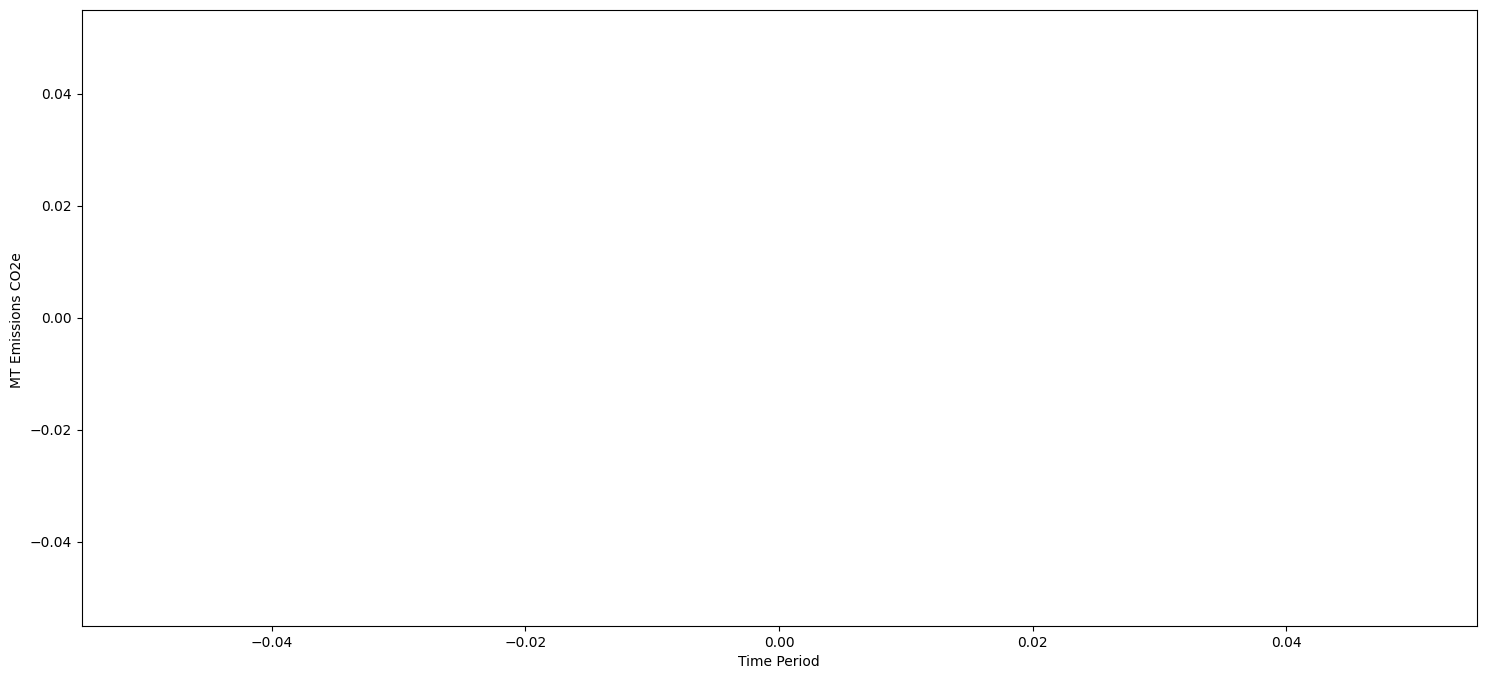

In [44]:

fig, ax = plt.subplots(figsize = (18, 8))
ax.set_xlabel("Time Period")
ax.set_ylabel("MT Emissions CO2e ")

df_plot = df_out[
    df_out[ssp.key_primary].isin([71071])
]


fields = matt.get_all_subsector_emission_total_fields()#[x for x in df_out.columns if (x.startswith("emission_co2e_subsector_total"))]
dict_format = dict(
    (k, {"color": v}) for (k, v) in
    matt.get_subsector_color_map().items()
)

fig, ax = spu.plot_stack(
    df_plot,
    fields,
    dict_formatting = dict_format,
    field_x = "time_period",
    figtuple = (fig, ax),
)


# Export Wide File (Last Mandatory Step)

In [45]:
df_out = ssp.read_output(None)
df_in = ssp.read_input(None)


all_primaries = sorted(list(df_out[ssp.key_primary].unique()))

# build if unable to simply read the data frame
if df_in is None:
    df_in = []
     
    for region in ssp.regions:
        for primary in all_primaries: 
            df_in_filt = ssp.generate_scenario_database_from_primary_key(primary)
            df_in.append(df_in_filt.get(region))
    
    df_in = pd.concat(df_in, axis = 0).reset_index(drop = True)




df_export = pd.merge(
    df_out,
    df_in,
    how = "left",
)



# check output directory 
dir_pkg = os.path.join(
    ssp.file_struct.dir_out, 
    f"sisepuede_summary_results_run_{ssp.id_fs_safe}"
)
os.makedirs(dir_pkg) if not os.path.exists(dir_pkg) else None


for tab in ["ATTRIBUTE_STRATEGY"]:
    table_df = ssp.database.db.read_table(tab)
    if table_df is not None:
        table_df.to_csv(
            os.path.join(dir_pkg, f"{tab}.csv"),
            index=None,
            encoding="UTF-8"
        )
    else:
        print(f"Warning: Table {tab} returned None.")


df_primary = (
    ssp
    .odpt_primary
    .get_indexing_dataframe(
        sorted(list(df_out[ssp.key_primary].unique()))
    )
)
    
df_primary.to_csv(
    os.path.join(dir_pkg, f"ATTRIBUTE_PRIMARY.csv"),
    index = None,
    encoding = "UTF-8"
)

df_export.to_csv(
    os.path.join(dir_pkg, f"sisepuede_results_{ssp.id_fs_safe}_WIDE_INPUTS_OUTPUTS.csv"),
    index = None,
    encoding = "UTF-8"
)

In [46]:
# Getting the directory where the outputs are stored
ssp.file_struct.dir_out

'/home/tony-ubuntu/anaconda3/envs/ssp_tanzania/lib/python3.11/site-packages/sisepuede/out'

## Some Optional Plotting

In [66]:
# primary_id = 0

# df_prim = df_out[
#     df_out[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]

# df_in_cur = df_in[
#     df_in[
#         ssp.key_primary
#     ]
#     .isin([primary_id])
# ]


# fields_plot = [
#     x for x in df_prim.columns
#     if "investment" in x
#     and df_prim[x].max() > 0
# ]
# (
#     df_prim[fields_plot]
#     .plot(
#         legend = True,
#     )
# )




In [67]:


# fig, ax = plt.subplots(figsize = (15, 10))
# df_resid = matt.extract_model_variable(
#     df_in_cur,
#     "NemoMod ResidualCapacity"
# )
# (
#     df_resid
#     .plot
#     .area(
#         ax = ax
#     )
# )

In [68]:
# df_resid

In [69]:
# [x for x in df_out.columns if "capacity" in x]

In [70]:
# ssp.model_attributes.configuration.dict_config


In [71]:
# modvar = matt.get_variable("NemoMod Generation Capacity")
# modvar.get_from_dataframe(df_prim).head()

In [72]:
# #[x for x in matt.all_variables if "Consumption" in x]
# [x for x in matt.all_variables if "Production" in x]
# modvar = matt.get_variable("NemoMod Production by Technology")


# unit = matt.get_unit("energy")
# (modvar.get_from_dataframe(df_prim).iloc[7].sum()*unit.convert("PJ", "mwh")/1000)/367669

In [73]:
# df_inputs

In [74]:
# modvar = matt.get_variable("Total Energy Consumption from Industrial Energy")#Industrial Energy")
# matt.extract_model_variable(
#     df_prim,
#     modvar
# )